In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.image as mpimg

import glob
import re
import pickle
import random

from tensorflow import keras
from tensorflow.keras import layers

scaler = preprocessing.MinMaxScaler((0,1))
plt.rcParams['savefig.dpi'] = 50

In [23]:
print(tf.__version__)

2.2.0


In [2]:
# 将读取的img转化为矩阵
def img_to_array(imageFile):
    img = mpimg.imread(imageFile).astype(np.float)
    img=img[:,:,0]
    img=1-img
    return img.reshape((50,50,1))

In [3]:
# 加载图片数据
path_0 = "./GWAC_data/train_0/*.png"
# path_0 = "./Finded_0909/*.png"
path_1 = "./GWAC_data/train_1/*.png"

pool_0=[imageFile for imageFile in glob.glob(path_0)]
pool_1=[imageFile for imageFile in glob.glob(path_1)]
print("len(pool_1)",len(pool_1))
print("len(pool_0)",len(pool_0))

train_sample_size = len(pool_1) + len(pool_0)
x_train = np.zeros((train_sample_size, 50,50,1))
y_train = np.zeros((train_sample_size,2))

len(pool_1) 10535
len(pool_0) 27488


In [11]:
### 把训练数据的顺序打乱，通过原来的顺序号num来判断标签而已。

y0=np.array([1,0]) # one-hot编码 0为非耀发
y1=np.array([0,1]) # one-hot编码 1为耀发


# positive 为标签为1 的样本的新的index
# positive 为标签为0 的样本的新的index
positive = []
negative = []
list1 = [x for x in range(0,train_sample_size)]
random.shuffle(list1)
for i,num in enumerate(list1):
    if num <len(pool_1):
        x_train[i] = img_to_array(pool_1[num])
        y_train[i] = y1
        positive.append(i)
    else:
        x_train[i] = img_to_array(pool_0[num-len(pool_1)-1])
        y_train[i] = y0
        negative.append(i)
        
        
x_train.shape

/home/wamdm/anaconda3/envs/tensorflow2.2.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


(38023, 50, 50, 1)

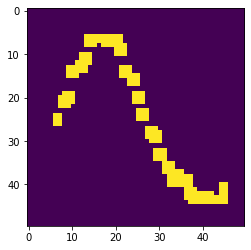

In [8]:
plt.imshow(x_train[5].reshape(50,50))

In [10]:
num_classes = 2
input_shape = (50,50,1)

#Modify LeNet
modelorigin = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(6, kernel_size=(5, 5),activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(16, kernel_size=(4, 4), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Flatten(),

        layers.Dense(120, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(84, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

modelorigin.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 6)         156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 16)        1552      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)              

In [13]:
from timeit import default_timer as timer
batch_size = 512
epochs = 10

# model.optimizer.lr.assign(0.00001)
modelorigin.compile(loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
start_time = timer()
modelorigin.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)
current_time = timer()
print("train_time",(current_time-start_time)/10)

Epoch 1/10
52/52 [==============================] - 6s 115ms/step - loss: 0.2840 - categorical_accuracy: 0.8815 - val_loss: 0.1142 - val_categorical_accuracy: 0.9642
Epoch 2/10
52/52 [==============================] - 6s 113ms/step - loss: 0.0856 - categorical_accuracy: 0.9707 - val_loss: 0.0509 - val_categorical_accuracy: 0.9827
Epoch 3/10
52/52 [==============================] - 6s 112ms/step - loss: 0.0522 - categorical_accuracy: 0.9832 - val_loss: 0.0355 - val_categorical_accuracy: 0.9895
Epoch 4/10
52/52 [==============================] - 6s 113ms/step - loss: 0.0347 - categorical_accuracy: 0.9894 - val_loss: 0.0267 - val_categorical_accuracy: 0.9912
Epoch 5/10
52/52 [==============================] - 6s 114ms/step - loss: 0.0262 - categorical_accuracy: 0.9917 - val_loss: 0.0289 - val_categorical_accuracy: 0.9916
Epoch 6/10
52/52 [==============================] - 6s 112ms/step - loss: 0.0211 - categorical_accuracy: 0.9933 - val_loss: 0.0148 - val_categorical_accuracy: 0.9957
Epoc

In [14]:
score = modelorigin.evaluate(x_train, y_train, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.005563006736338139
Test accuracy: 0.9982116222381592


In [15]:
## 保存模型
mp = "./LeNet_"+ "batch_size_"+ str(batch_size) + "_" + "epochs_"+ str(epochs) + "_" + "kernel_size_" + "543" + "_" + "accuracy_" + str(score[1]) + ".h5"
modelorigin.save(mp)

In [17]:
from sklearn.metrics import confusion_matrix
true_y=np.apply_along_axis(np.argmax,1,y_train)

pred_y=modelorigin.predict(x_train)
pred_y=np.apply_along_axis(np.argmax,1,pred_y)

confusion_mat = confusion_matrix(true_y, pred_y)

print(confusion_mat)

array([[27421,    67],
       [    1, 10534]])

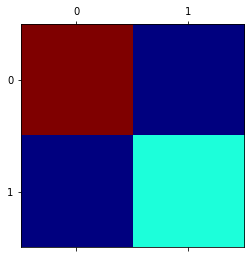

In [18]:
plt.matshow(confusion_mat, cmap='jet')#viridis,jet_r,rainbow

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_y,pred_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27488
           1       0.99      1.00      1.00     10535

    accuracy                           1.00     38023
   macro avg       1.00      1.00      1.00     38023
weighted avg       1.00      1.00      1.00     38023



In [21]:
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import models
from scipy import interpolate

In [22]:
### 绘制CAM热力图
def heatmapcam(img,i):
    last_conv_layer='conv2d_2'
    predicts=model.predict(img)
    print(np.argmax(predicts[0]),predicts[0].max())

    # get the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer)

    heatmap_model = models.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, Predictions = heatmap_model(img)
#         print("Predictions",Predictions)
        prob = Predictions[:, np.argmax(Predictions[0])] # 最大可能性类别的预测概率
#         print("prob",prob)
        grads = gtape.gradient(prob, conv_output)  # 类别与卷积层的梯度 
        pooled_grads = K.mean(grads, axis=(0,1,2)) # 特征层梯度的全局平均代表每个特征层权重
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1) #权重与特征层相乘，512层求和平均

    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    # plt.matshow(heatmap[0], cmap='jet')#viridis,jet_r,rainbow


    heatmap_sample=heatmap[0]
#     print("heatmap_sample",heatmap_sample)
    cov_size=4
    x = np.arange(0, cov_size, 1)
    y = np.arange(0, cov_size, 1)

    f = interpolate.interp2d(x, y, heatmap_sample, kind='cubic')

    xnew = np.linspace(0, cov_size, 50)
    ynew = np.linspace(0, cov_size, 50)
    znew = f(xnew, ynew)

    plt.matshow(znew, cmap='jet')#viridis,jet_r,rainbow
    plt.tight_layout()
    
#     文件名的第一位表示这是第几个热力图。第二位为预测标签，第三位表示以多大概率预测为此标签
    plt.savefig('./heatmap543/'+ str(i) + '_'+ str(np.argmax(predicts[0])) +'_'+ str(predicts[0].max())+'.png')
    ## cmap='Greys_r'表示画出的图为灰度图
    plt.imshow(img.reshape(50,50),cmap='Greys_r',alpha=0.5)
    plt.savefig('./heatmap543/'+ str(i) + '_'+ str(np.argmax(predicts[0])) +'_'+ str(predicts[0].max())+'.png')
#     plt.clf()#添加上这一行，画完图后，重置一下
    plt.close()

In [27]:
### 画出标签为1的热力图，但模型的判断结果不一定为1
for i in positive :
    img=x_train[i].reshape(1,50,50,1)
    heatmapcam(img,i)

1 0.8042555


/home/wamdm/anaconda3/envs/tensorflowCPU/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


1 0.93864274
0 0.58764327
0 0.605559
1 0.91245157
1 0.56543416
0 0.99362576
1 0.90776086
0 0.94531125
1 0.8309857
0 0.9644483
1 0.9145734
1 0.8659951
1 0.84120584
1 0.6485057
1 0.8644202
1 0.83473665
0 0.9368888
1 0.5738156
1 0.6572635
1 0.8104265


/home/wamdm/anaconda3/envs/tensorflowCPU/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1 0.9226676
1 0.8761867
1 0.8607055
1 0.82021207
1 0.93241763
1 0.84475166
1 0.61124486
0 0.99017566
0 0.60075104
1 0.9051799
1 0.75798476
0 0.6777121
1 0.90388125
1 0.9076417
1 0.8589979
1 0.8753609
1 0.6118951
1 0.7464554
1 0.6502781
1 0.9278306
1 0.90521514
0 0.9368888
1 0.9270885
1 0.92232037
1 0.8983389
1 0.8468247
0 0.95074105
1 0.72219265
1 0.69827676
1 0.91476715
1 0.9021162
1 0.91433436
1 0.9224597
1 0.9214373
1 0.8605947
0 0.5265797
1 0.8995628
1 0.89635134
1 0.88407636
1 0.90087044
1 0.9338192
1 0.9342976
1 0.8979165
1 0.8901812
1 0.9075715
1 0.93163043
1 0.56062526
1 0.91567713
1 0.92055124
1 0.90172684
1 0.59295267
1 0.81950545
1 0.9241782
1 0.8478239
1 0.8699584
1 0.7893885
1 0.85777944
1 0.9365711
1 0.879484
1 0.9153731
1 0.8970788
1 0.902504
1 0.92448574
1 0.90468144
1 0.93688565
1 0.8699584
1 0.6550129
1 0.7956673
1 0.75339293
1 0.92055327
0 0.6208199
1 0.78396446
1 0.9079439
1 0.9373939
1 0.81093305
1 0.8659951
1 0.86438614
1 0.6859661
1 0.928974
1 0.9194639
1 0.88455

KeyboardInterrupt: 

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>